In [2]:
import numpy as np
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import ConvexHull
import scipy.optimize
import random
import pandas as pd
%matplotlib notebook
sns.set()

# Production constraints
## Alice in agricultural land
- Alice has a field on which she can grow 3 units of potatoes, or 4 units of carrots
- The fields has a uniform yield

Find a way to express what she can grow in Python.

## Here comes bob
- Bob also has a field, on which he can grow 2 units of potatoes, or 1 unit of carrots
- His field also has a uniform yield

Parametrize your solution so that it can check the production constraints for both Alice and Bob.

In [3]:
bounds = {
    "alice": {
        "potato": 3,
        "carrot": 4,
    },
    "bob": {
        "potato": 2,
        "carrot": 1,
    },
}

def check_bounds(bounds, farmer, potato, carrot):
    """Check that the given farmer can produce the given amounts of vegetables"""
    return potato/bounds[farmer]["potato"] + carrot/bounds[farmer]["carrot"] <= 1

# Consumption preferences
Alice has a relative (and fixed) preference for carrots over potatoes. Or maybe it's the opposite way ? Anyway, find a parametrized way to express a relative fixed preference (or dislike) for carrots over potatoes.

In [4]:
def get_linear_price(ratio):
    """Return a bilinear price function"""
    def price(potato, carrot):
        potato_price = 1  # €/potato
        carrot_price = potato_price*ratio
        return potato*potato_price + carrot*carrot_price
    return price

<IPython.core.display.Javascript object>


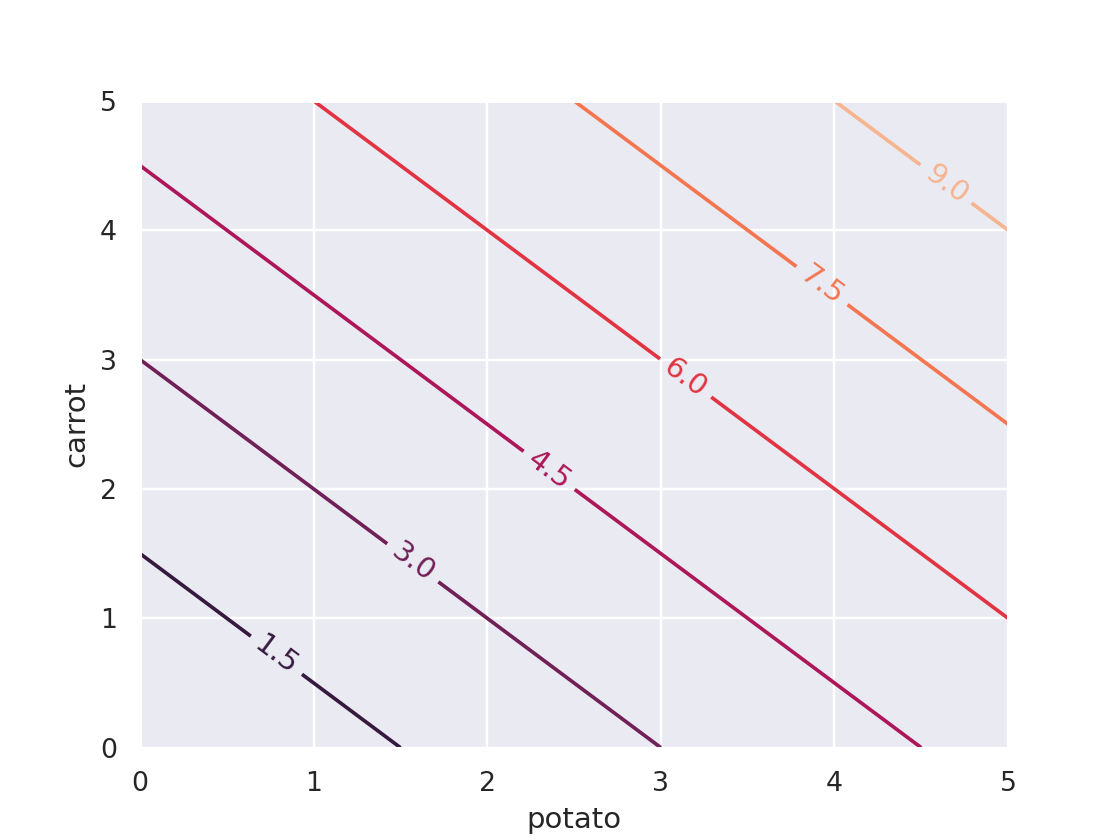

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [5]:
def ratio_widget():
    return widgets.FloatLogSlider(value=1, base=2, min=-5, max=5, step=.25)
def clean_plot(f):
    """Boilerplate to let f draw stuff"""
    global fig
    def g(*args, clean=True, **kwargs):
        global fig
        if clean:
            fig.clf()
        answer = f(*args, **kwargs)
        if clean:
            fig.show()
        return answer
    return g

@clean_plot
def plot_market_landscape(ratio, ax=None, price_for=get_linear_price):
    ax = ax if ax is not None else plt.gca()
    X,Y = np.meshgrid(np.linspace(0, sum([bounds[f]["potato"] for f in bounds if f != "both"]), num=15),
                      np.linspace(0, sum([bounds[f]["carrot"] for f in bounds if f != "both"]), num=15))
    Z = price_for(ratio)(X, Y)
    cs = ax.contour(X, Y, Z)
    ax.clabel(cs)
    ax.set_xlabel("potato")
    ax.set_ylabel("carrot")

fig = plt.figure()
widgets.interact(plot_market_landscape, ratio=ratio_widget(), clean=widgets.fixed(True))

# Solipsistic optimization
Let Alice and Bob find out how much of each vegetable they should produce.

<IPython.core.display.Javascript object>


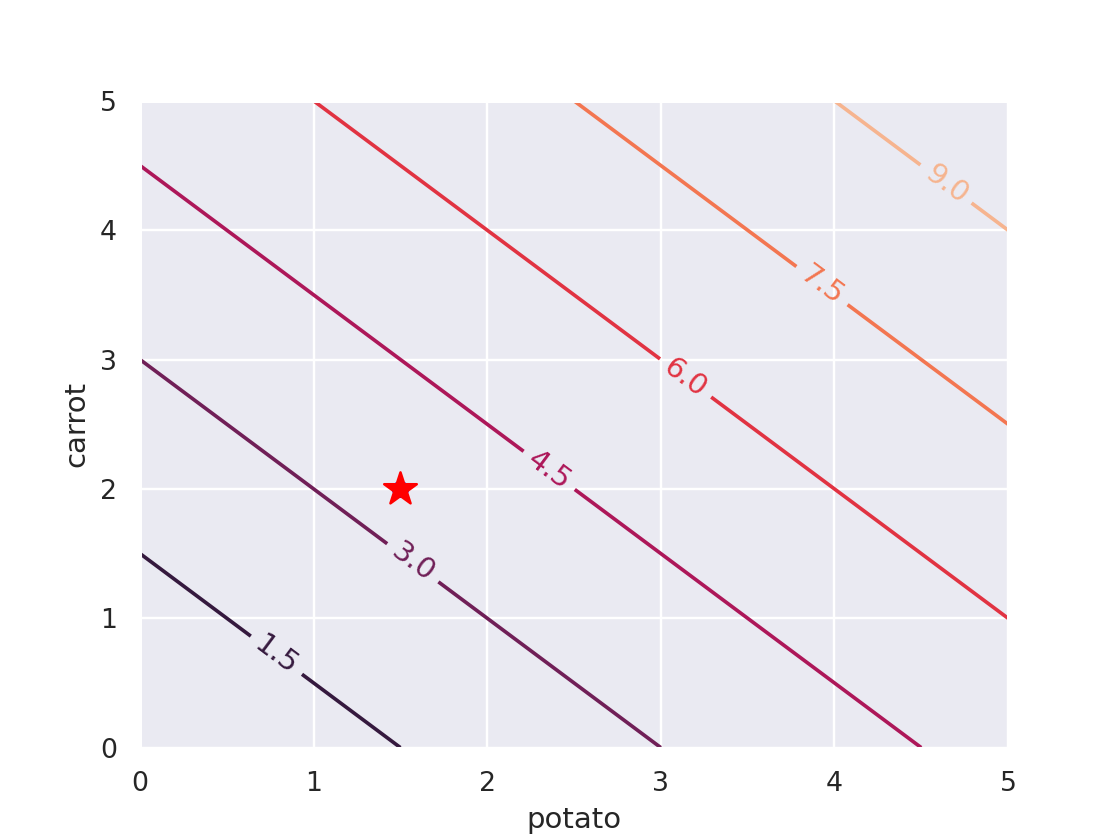

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [6]:
def get_best(price_for=get_linear_price):
    """Return a function that can evaluate which potato, carrot couple is the best for the given price"""
    def best(ratio, *args):
        """Return the best of the (potato, carrot) couples given in arguments"""
        price = price_for(ratio)
        best_price = -float("inf")
        best_potato = None
        best_carrot = None
        for potato, carrot in args:
            if potato is not None and carrot is not None and \
            (p := price(potato, carrot)) > best_price:
                best_potato = potato
                best_carrot = carrot
                best_price = p
        return best_price, best_potato, best_carrot
    return best

class State:
    def __init__(self, ratio, price_for=get_linear_price):
        self._ratio = ratio
        self.price_for = price_for
        self.bestf = get_best(price_for)
        self.best_price, self.best_potato, self.best_carrot = self.bestf(ratio)

    @property
    def ratio(self):
        return self._ratio
    
    @ratio.setter
    def ratio(self, ratio):
        """Reset the state if the ratio changes"""
        if ratio != self._ratio:
            self.__init__(ratio, price_for=self.price_for)
            
    def scatter(self, ax=plt):
        """Plot the best known point so far"""
        if self.best_potato is None and self.best_carrot is None:
            return
        print(f'Best so far: {self.best_price}')
        ax.scatter(self.best_potato,
                    self.best_carrot,
                    color="red", marker="*", s=200)
    
    @property
    def current_vegetables(self):
        return self._current_vegetables
    
    @current_vegetables.setter
    def current_vegetables(self, vegetables):
        potato, carrot = vegetables
        self.best_price, self.best_potato, self.best_carrot = self.bestf(
            self._ratio,
            [self.best_potato, self.best_carrot],
            [potato, carrot])

@clean_plot
def plot_farmer(farmer, ratio, potato, carrot, ax=None, price_for=get_linear_price):
    """Plot the given point for the given farmer, along with the best point so far"""
    ax = ax if ax is not None else plt.gca()
    plot_farmer.state.ratio = ratio
    plot_market_landscape(ratio, clean=False, ax=ax, price_for=price_for)
    answer = f"{farmer} can't produce that much"
    if check_bounds(bounds, farmer, potato, carrot):
        plot_farmer.state.current_vegetables = [potato, carrot]
        ax.scatter(potato, carrot, color="blue")
        answer = price_for(ratio)(potato, carrot)
    plot_farmer.state.scatter(ax=ax)
    return answer
plot_farmer.state = State(None)

fig = plt.figure()
widgets.interact(plot_farmer, farmer=widgets.fixed("alice"),
                 ratio=ratio_widget(),
                 potato=(0., bounds["alice"]["potato"]),
                 carrot=(0., bounds["alice"]["carrot"]),
                 clean=widgets.fixed(True))

In [7]:
def envelope(bounds, farmers):
    """Returns the coordinates of the feasible zone for the given farmers"""
    # First collect all the extreme points, i.e. those where each farmer goes either full potato
    # or full carrot
    points = [[0, 0]]
    for combination in itertools.product(*[["potato", "carrot"]]*len(farmers)):
        # combination goes over the list of words of length n with alphabet ["potato", "carrot"]
        current_point = {"potato": 0, "carrot": 0}
        for farmer, vegetable in zip(farmers, combination):
            current_point[vegetable] += bounds[farmer][vegetable]
        points += [[current_point["potato"], current_point["carrot"]]]
    points = np.array(points)
    # Now we compute the convex hull of this
    hull = ConvexHull(points)
    return points[hull.vertices, 0], points[hull.vertices, 1]
    

<IPython.core.display.Javascript object>


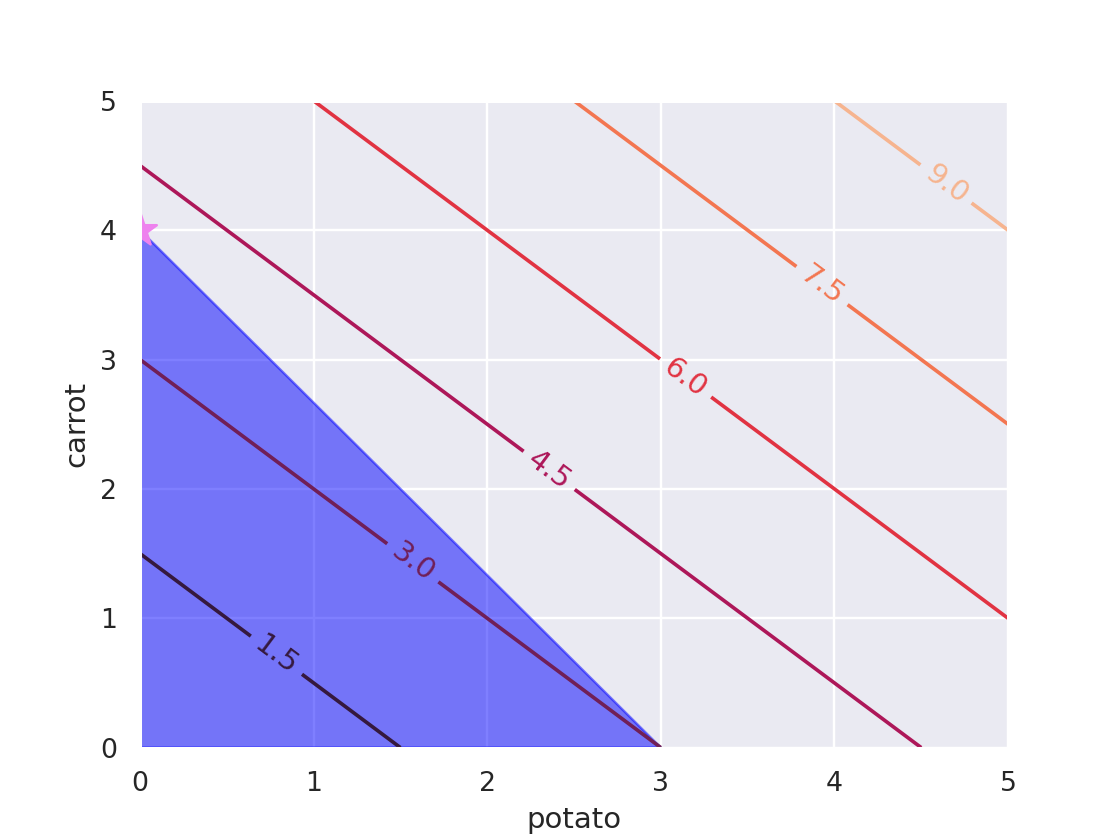

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [8]:
@clean_plot
def plot_feasible_zone(bounds, farmer, color, ratio, ax=None, price_for=get_linear_price):
    ax = ax if ax is not None else plt.gca()
    plot_market_landscape(ratio, clean=False, ax=ax, price_for=price_for)
    feasible_zone_potato, feasible_zone_carrot = envelope(bounds, farmer)
    ax.fill(feasible_zone_potato,
             feasible_zone_carrot,
             color = color,  alpha=.5)
    price, potato, carrot = get_best(price_for)(ratio, 
                             *[[potato, carrot] 
                               for potato, carrot in zip(feasible_zone_potato, feasible_zone_carrot)])
    ax.scatter(potato, carrot, color="violet", marker="*", s=200)
    return price

fig = plt.figure()
widgets.interact(plot_feasible_zone, bounds=widgets.fixed(bounds),
                 farmer=widgets.fixed(["alice"]), color=widgets.fixed("blue"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


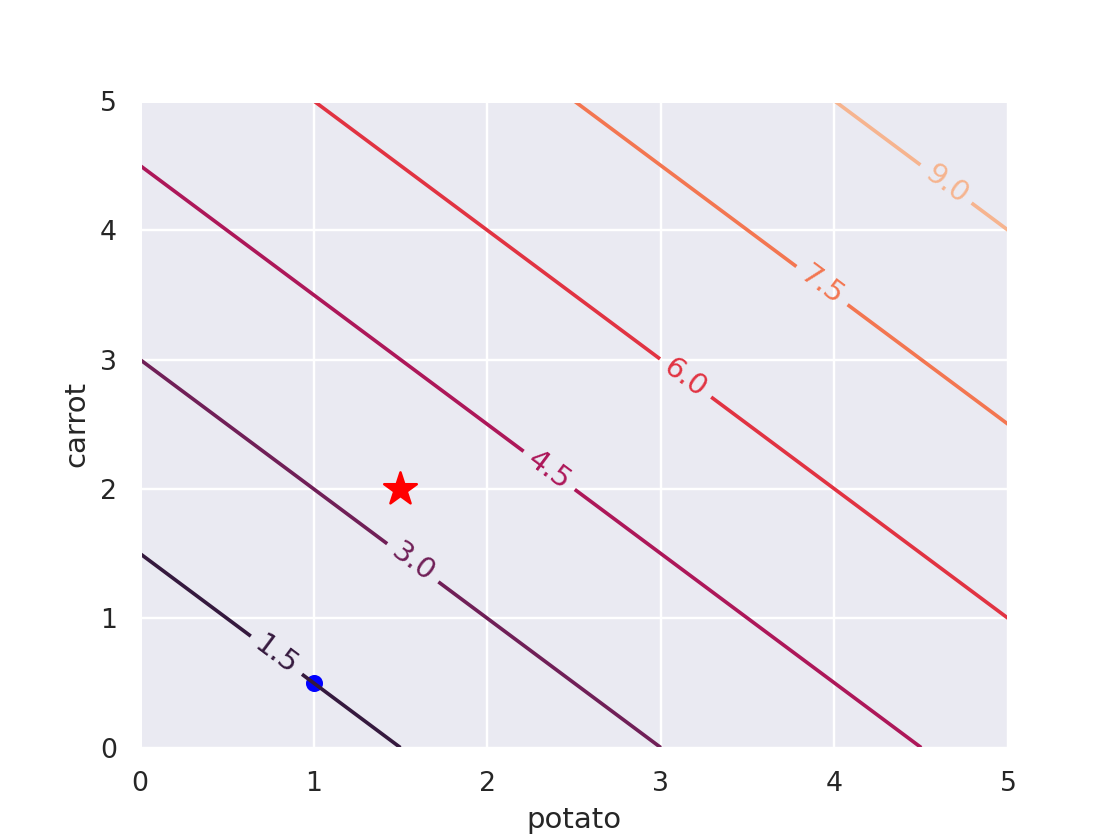

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [9]:
fig = plt.figure()
#plot_farmer.state = State(None)
widgets.interact(plot_farmer, farmer=widgets.fixed("bob"), ratio=ratio_widget(),
                 potato=(0., bounds["bob"]["potato"]),
                 carrot=(0., bounds["bob"]["carrot"]),
                 clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


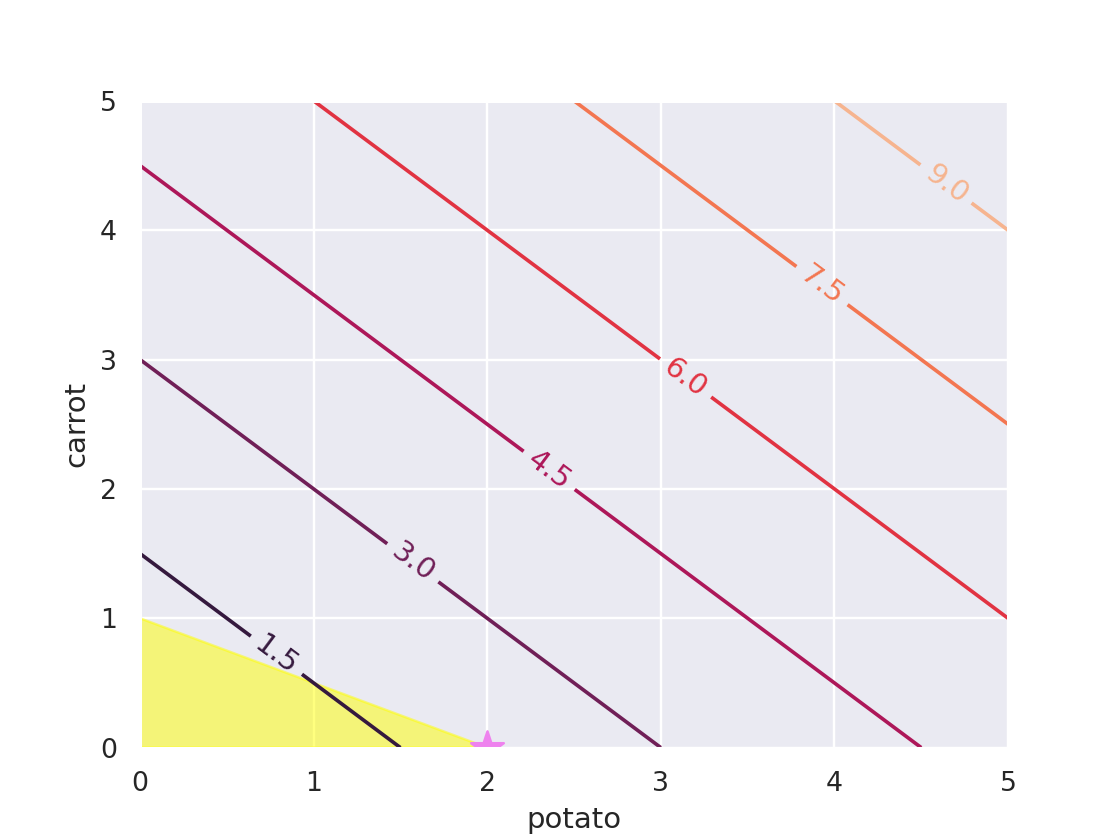

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [10]:
fig = plt.figure()
widgets.interact(plot_feasible_zone, bounds=widgets.fixed(bounds),
                 farmer=widgets.fixed(["bob"]), color=widgets.fixed("yellow"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

# Combined optimization
Alice and Bob study the opportunity of working together.

They compute that if they both go "full potato", they'll get 5 units of potatoes, and also, 5 units of carrots if they go "full carrot".

What does their feasible region look like ?

<IPython.core.display.Javascript object>


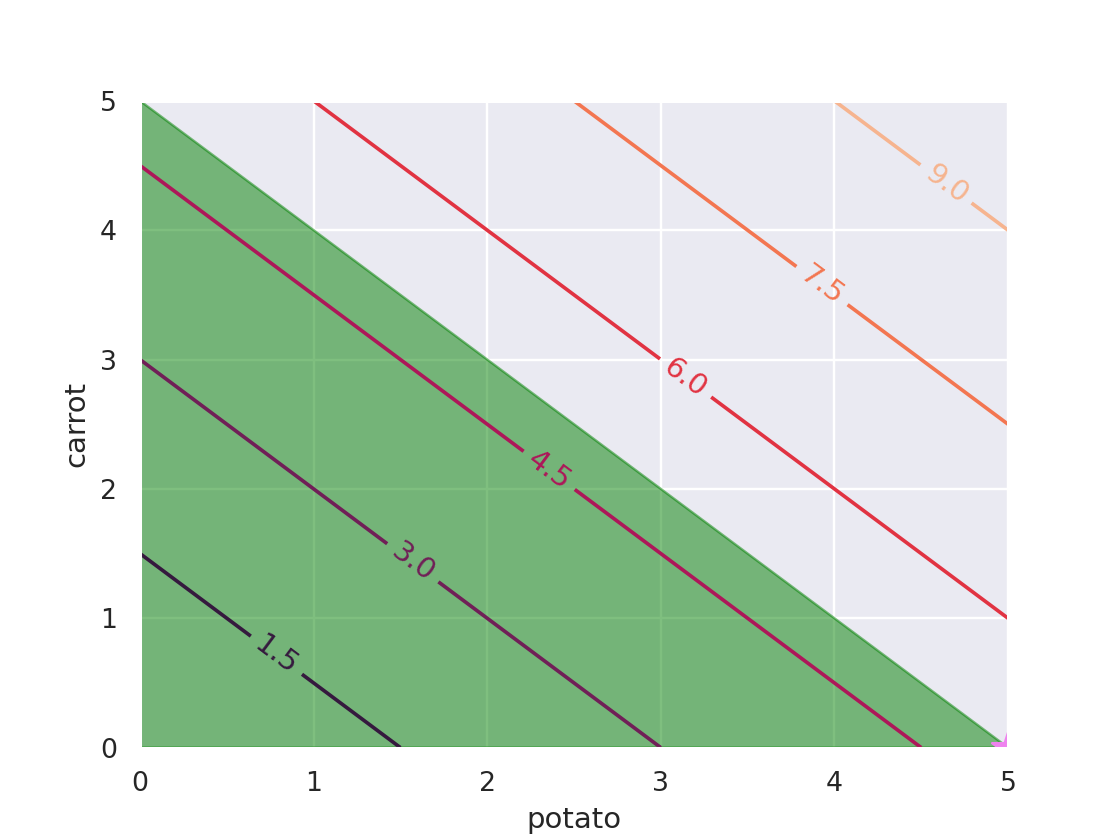

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [11]:
fig = plt.figure()
bothbounds = {"both":{"potato": sum(bounds[f]["potato"] for f in ["alice", "bob"]),
                     "carrot": sum(bounds[f]["carrot"] for f in ["alice", "bob"])}}
widgets.interact(plot_feasible_zone, bounds=widgets.fixed(bothbounds),
                 farmer=widgets.fixed(["both"]), color=widgets.fixed("green"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


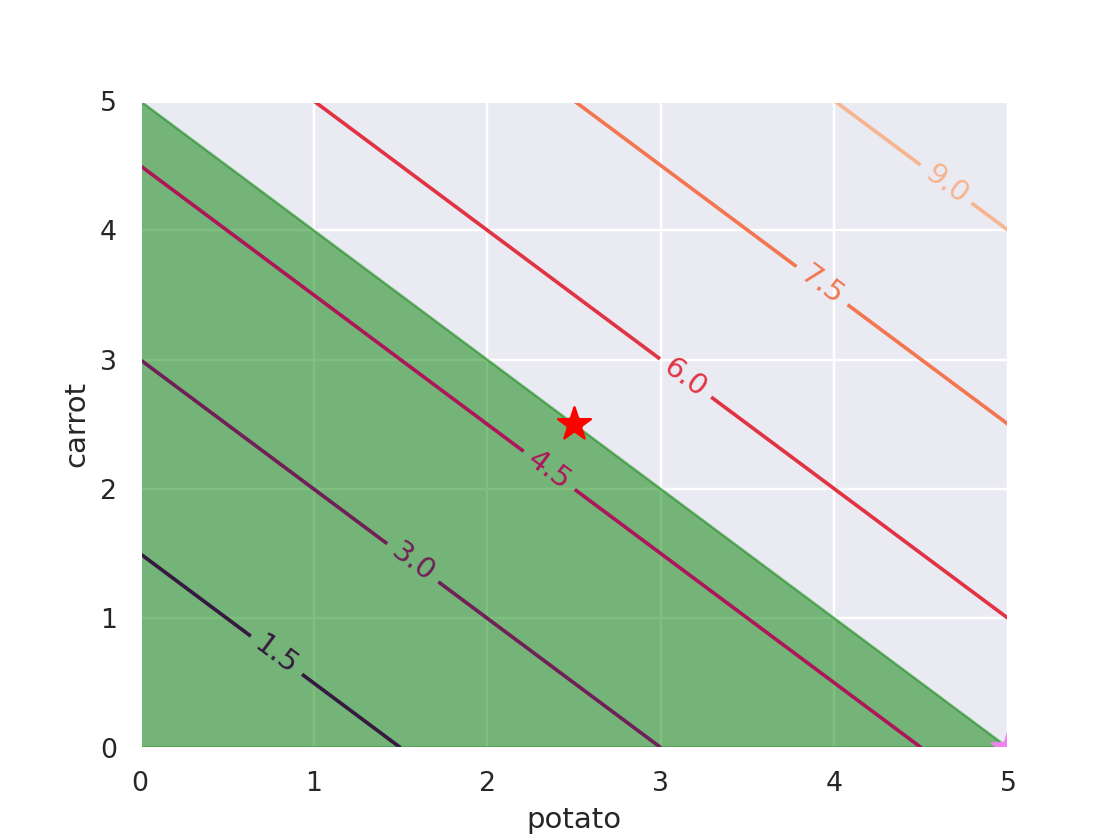

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [12]:
@clean_plot
def plot_both_farmers_naive(ratio, alice_potato, alice_carrot, bob_potato, bob_carrot, ax=None):
    """Plot the given point, along with the best point so far"""
    ax = ax if ax is not None else plt.gca()
    plot_both_farmers_naive.state.ratio = ratio
    plot_feasible_zone(farmer=["both"], bounds=bothbounds, ratio=ratio, clean=False, color="green", ax=ax)
    if not check_bounds(bounds, "alice", alice_potato, alice_carrot):
        return "Alice can't produce that much"
    if not check_bounds(bounds, "bob", bob_potato, bob_carrot):
        return "Bob can't produce that much"
    potato = alice_potato + bob_potato
    carrot = alice_carrot + bob_carrot
    plot_both_farmers_naive.state.current_vegetables = [potato, carrot]
    ax.scatter(potato, carrot, color="green")
    plot_both_farmers_naive.state.scatter(ax=ax)
    return get_linear_price(ratio)(potato, carrot)
plot_both_farmers_naive.state = State(None)

fig = plt.figure()
widgets.interact(plot_both_farmers_naive, ratio=ratio_widget(),
                 clean=widgets.fixed(True),
                 alice_potato=(0., bounds["alice"]["potato"]),
                 alice_carrot=(0., bounds["alice"]["carrot"]),
                 bob_potato=(0., bounds["bob"]["potato"]),
                 bob_carrot=(0., bounds["bob"]["carrot"]),
                )

<IPython.core.display.Javascript object>


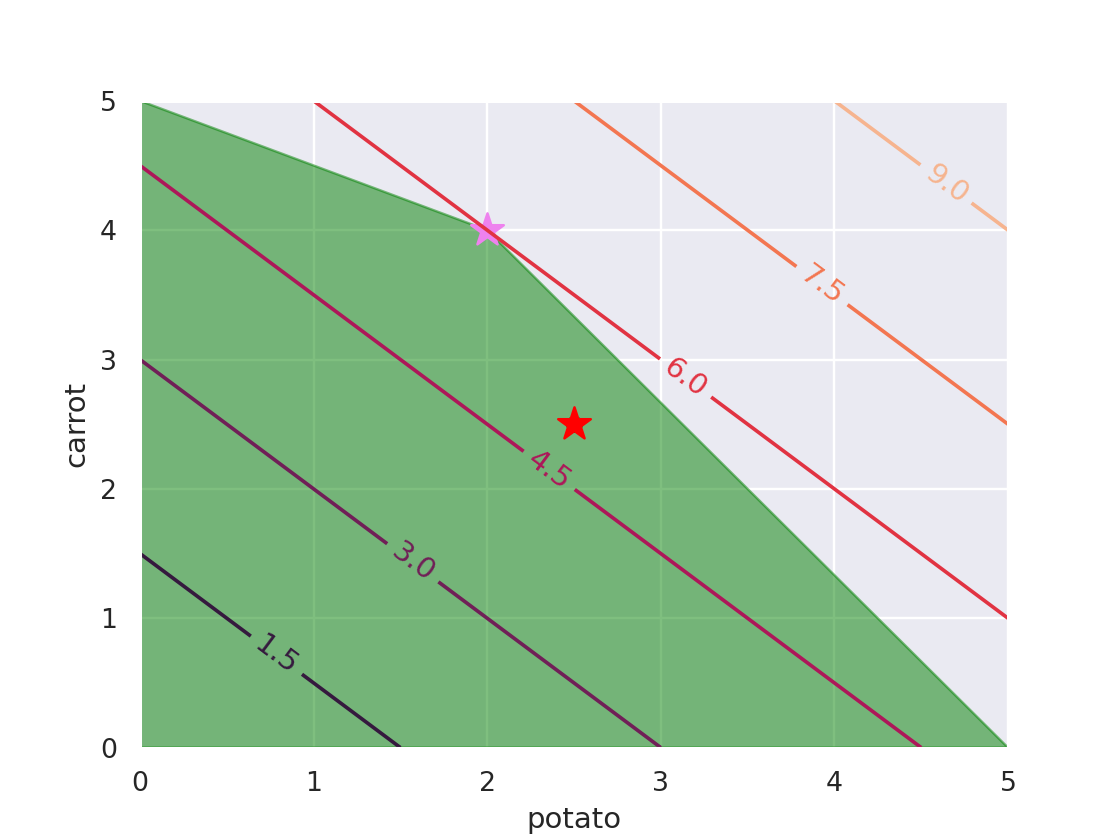

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [13]:
@clean_plot
def plot_both_farmers(ratio, alice_potato, alice_carrot, bob_potato, bob_carrot, ax=None):
    """Plot the given point, along with the best point so far"""
    ax = ax if ax is not None else plt.gca()
    plot_both_farmers.state.ratio = ratio
    plot_feasible_zone(farmer=["alice", "bob"], bounds=bounds, ratio=ratio, clean=False, color="green", ax=ax)
    if not check_bounds(bounds, "alice", alice_potato, alice_carrot):
        return "Alice can't produce that much"
    if not check_bounds(bounds, "bob", bob_potato, bob_carrot):
        return "Bob can't produce that much"
    potato = alice_potato + bob_potato
    carrot = alice_carrot + bob_carrot
    plot_both_farmers.state.current_vegetables = [potato, carrot]
    ax.scatter(potato, carrot, color="green")
    plot_both_farmers.state.scatter(ax=ax)
    return get_linear_price(ratio)(potato, carrot)
plot_both_farmers.state=State(None)

fig = plt.figure()
widgets.interact(plot_both_farmers, ratio=ratio_widget(),
                 alice_potato=(0., bounds["alice"]["potato"]),
                 alice_carrot=(0., bounds["alice"]["carrot"]),
                 bob_potato=(0., bounds["bob"]["potato"]),
                 bob_carrot=(0., bounds["bob"]["carrot"]),
                 clean=widgets.fixed(True)
                )

<IPython.core.display.Javascript object>


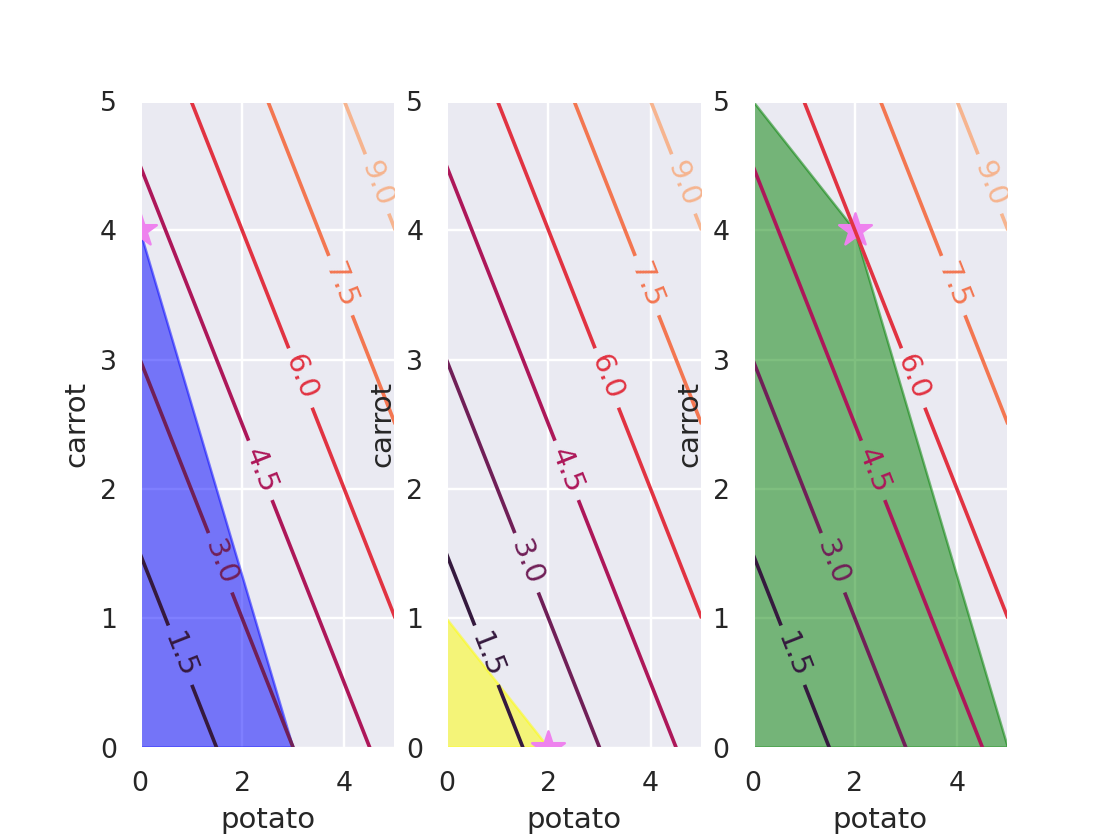

In [14]:
def plot_three_panes(ratio):
    """Plot alice, bob, and then alice and bob"""
    plot_three_panes.fig.clf()
    ax1 = plot_three_panes.fig.add_subplot(131)
    ax2 = plot_three_panes.fig.add_subplot(132)
    ax3 = plot_three_panes.fig.add_subplot(133)
    plot_feasible_zone(bounds=bounds, farmer=["alice"], ratio=ratio, color="blue", ax=ax1, clean=False)
    plot_feasible_zone(bounds=bounds, farmer=["bob"], ratio=ratio, color="yellow", ax=ax2, clean=False)
    plot_feasible_zone(bounds=bounds, farmer=["alice", "bob"], ratio=ratio, color="green", ax=ax3, clean=False)
    #plot_three_panes.fig.show()
    return plot_three_panes.fig
plot_three_panes.fig = plt.figure()

In [15]:
#plot_three_panes(ratio=6)
#fig.show()
widgets.interact(plot_three_panes, ratio=ratio_widget(),
                 alice_potato=(0., bounds["alice"]["potato"]),
                 alice_carrot=(0., bounds["alice"]["carrot"]),
                 bob_potato=(0., bounds["bob"]["potato"]),
                 bob_carrot=(0., bounds["bob"]["carrot"]),
                 #clean=widgets.fixed(True)
                )

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.plot_three_panes(ratio)>

<IPython.core.display.Javascript object>


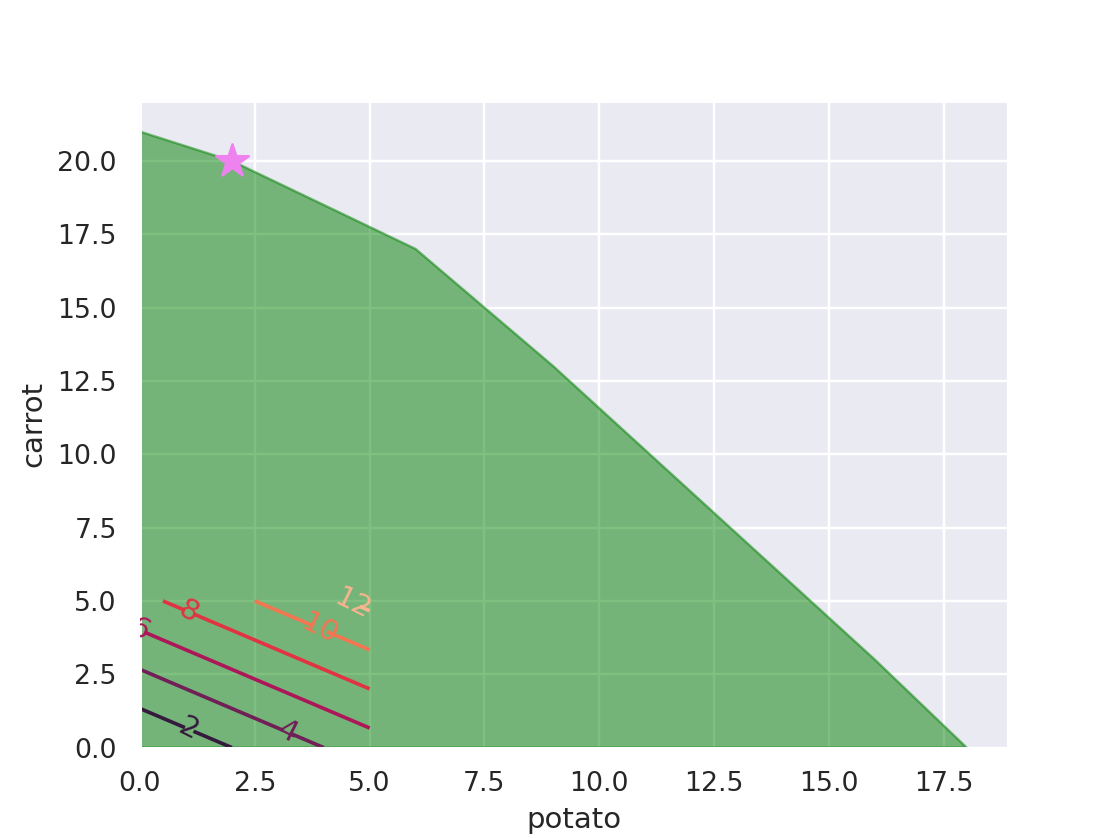

32.0

In [16]:
_bounds = bounds.copy()
_bounds["charlie"] = {"potato": random.randint(1, 10), "carrot": random.randint(1, 10)}
_bounds["Dave"] = {"potato": random.randint(1, 10), "carrot": random.randint(1, 10)}
_bounds["Felix"] = {"potato": random.randint(1, 10), "carrot": random.randint(1, 10)}
fig=plt.figure()
plot_feasible_zone(_bounds, _bounds.keys(),ratio=1.5, color="green")

# Decreasing marginal utility
Your first kg of carrots is important to make a soup. But after the fifth ton, eating carrots becomes tiresome. 

The relative preference (or dislike) for carrots over potatoes is not fixed, and should depend on how many carrots and potatoes you already have.

Try to find a value function that exhibits a decreasing marginal utility for both carrots and potatoes.


In [17]:
def get_sublinear_price(ratio):
    """Return a sublinear price function"""
    def price(potato, carrot):
        potato_price = 1  # €/potato
        carrot_price = potato_price*ratio
        return np.sqrt(potato)*potato_price + np.sqrt(carrot)*carrot_price
    return price

<IPython.core.display.Javascript object>


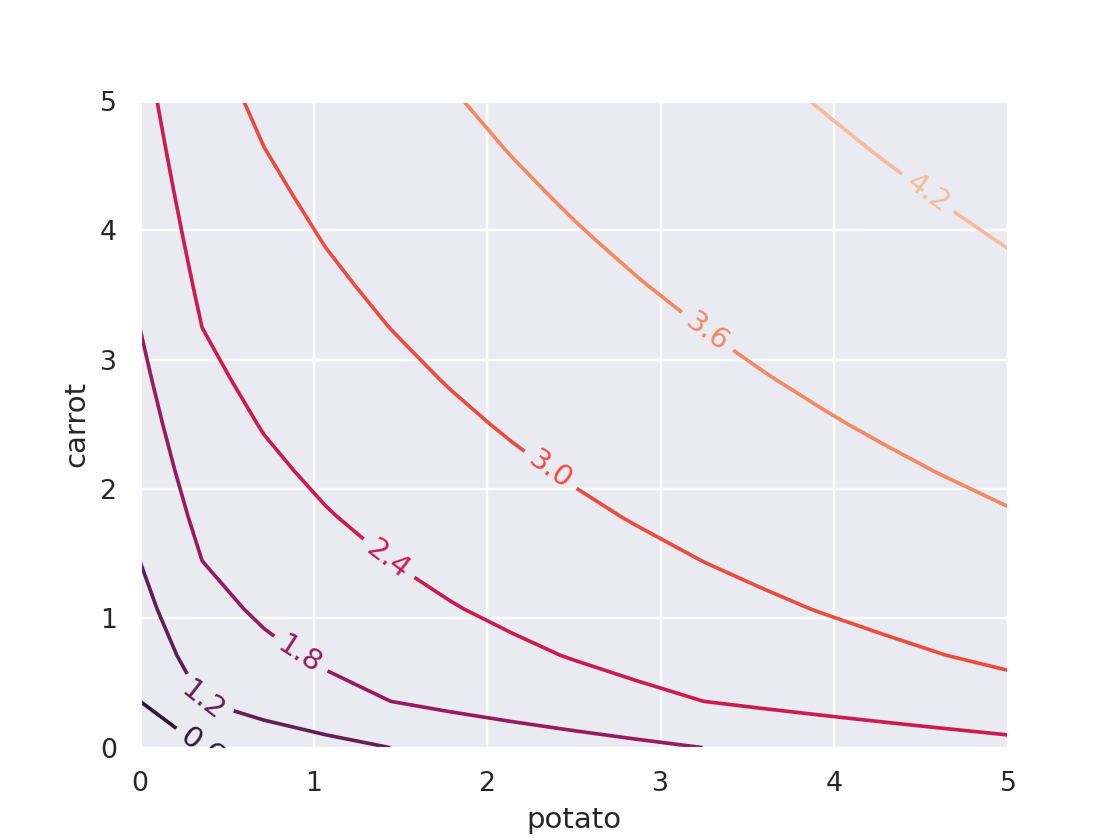

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [18]:
fig = plt.figure()
widgets.interact(plot_market_landscape, ratio=ratio_widget(),
                 clean=widgets.fixed(True),
                 price_for=widgets.fixed(get_sublinear_price))

# Linear assumptions don't hold anymore
## Extrema
Are not necessarily on the vertices anymore

<IPython.core.display.Javascript object>


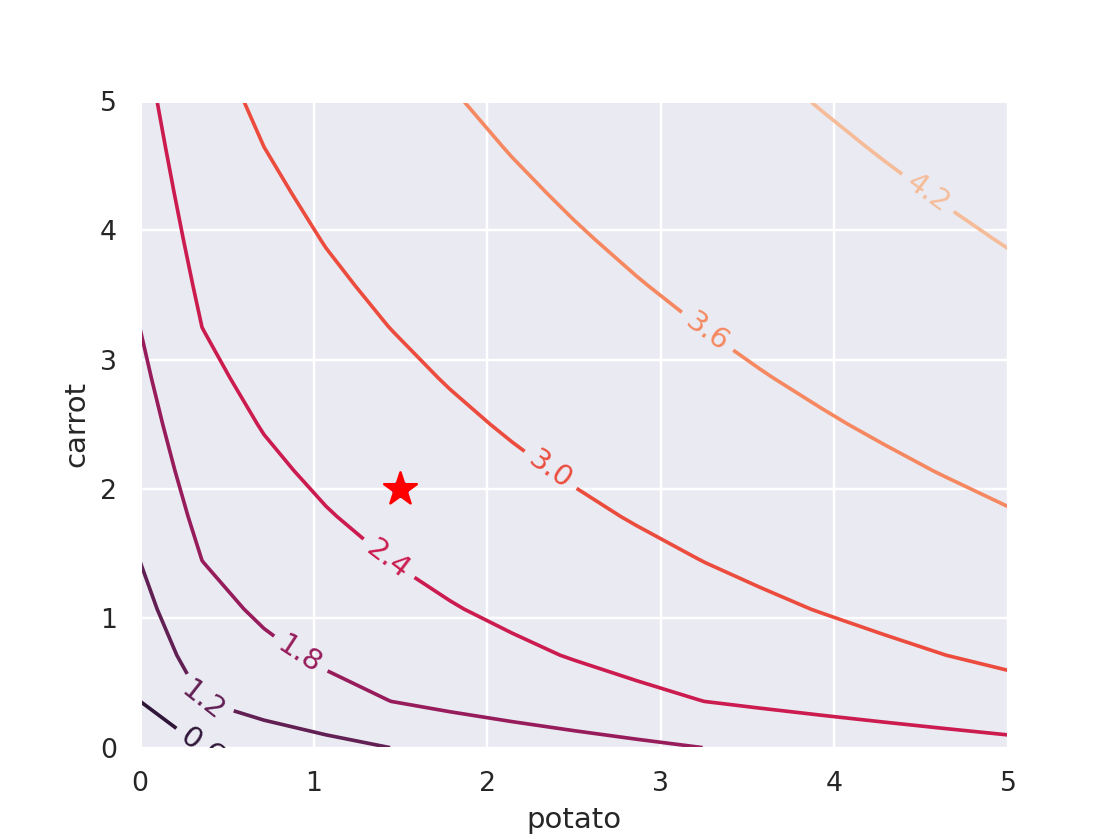

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [19]:
fig = plt.figure()
plot_farmer.state = State(None, price_for=get_sublinear_price)
widgets.interact(plot_farmer, farmer=widgets.fixed("alice"),
                 ratio=ratio_widget(),
                 potato=(0., bounds["alice"]["potato"]),
                 carrot=(0., bounds["alice"]["carrot"]),
                 clean=widgets.fixed(True),
                 price_for=widgets.fixed(get_sublinear_price))

<IPython.core.display.Javascript object>


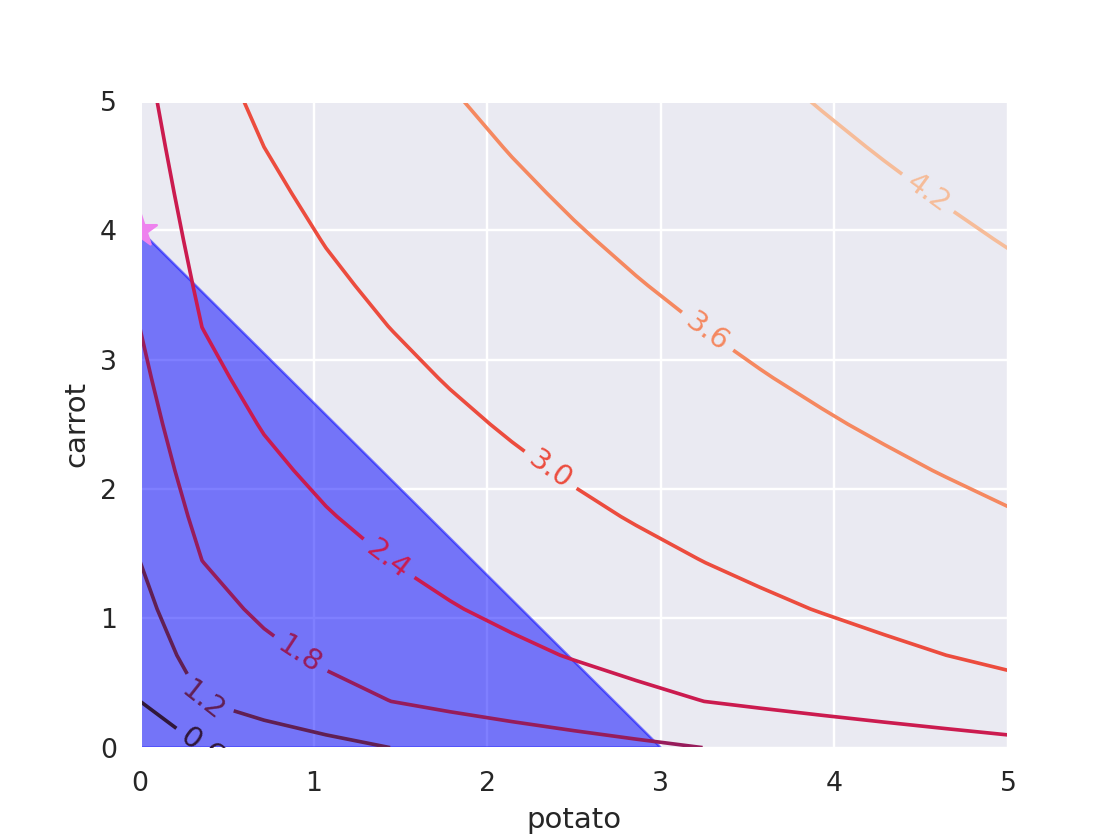

2.0

In [20]:
fig = plt.figure()
plot_feasible_zone(bounds, farmer=["alice"], color="blue", ratio=1, price_for=get_sublinear_price)

In [21]:
def optimize_nonlinear_prize(price, bounds, farmers):
    """Return the best aggregate price, and concatenated (potato, carrot) vectors
    for the given price function and farmers"""
    x0 = np.zeros(len(farmers)*2)  # Concatenation of the potato, carrot vectors of each farmer
    A = np.zeros((len(farmers), len(farmers)*2))  # One line per farmer, one column per farmer*vegetable
    for i, farmer in enumerate(farmers):
        A[i, 2*i:2*i+2] = np.array([1/bounds[farmer]["potato"],
                                   1/bounds[farmer]["carrot"]])
    #print(A)
    oresult= scipy.optimize.minimize(fun=lambda x: -price(sum(x[0::2]), sum(x[1::2])),
                                     x0 = x0,
                                     constraints = [
                                         scipy.optimize.LinearConstraint(
                                             A,
                                             np.zeros(len(farmers)),
                                             np.ones(len(farmers))),
                                         scipy.optimize.LinearConstraint(
                                             np.identity(len(farmers)*2),
                                             np.zeros(len(farmers)*2))],
                                     method="trust-constr",
                                    )
    return -oresult.fun, oresult.x

<IPython.core.display.Javascript object>


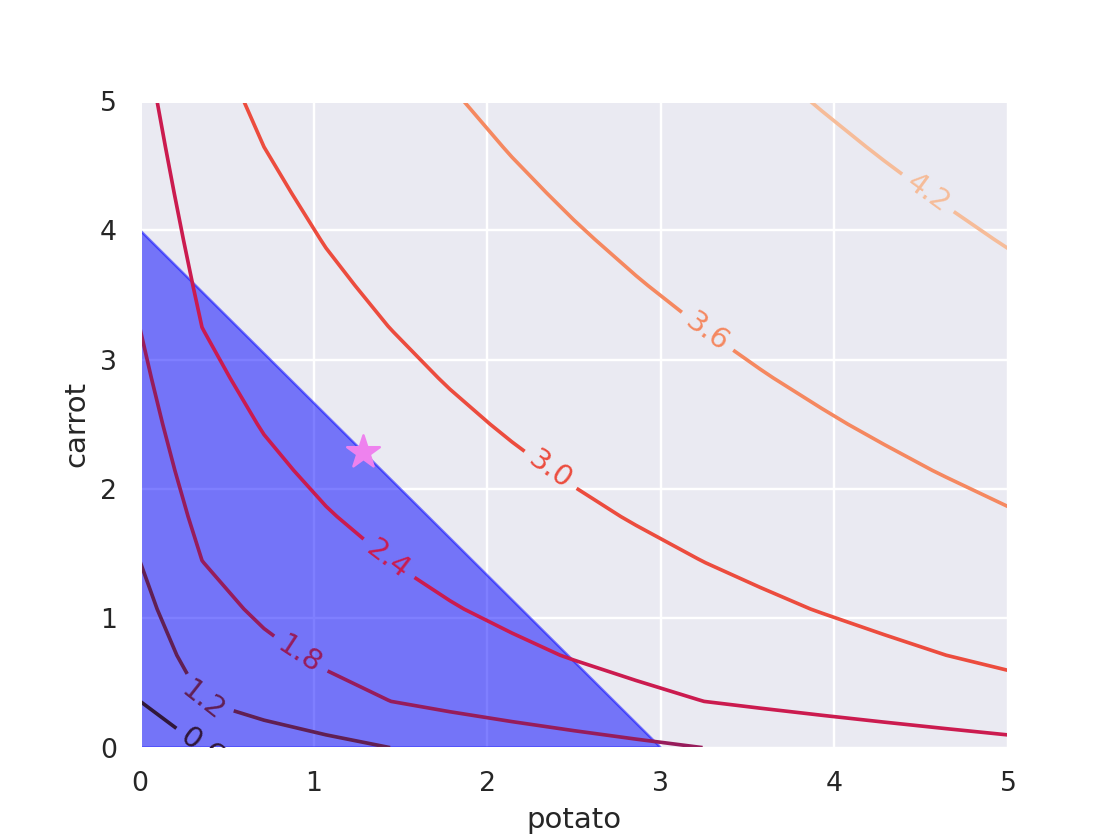

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [22]:
@clean_plot
def plot_feasible_zone_nonlinear(bounds, farmer, color, ratio, ax=None, price_for=get_sublinear_price):
    ax = ax if ax is not None else plt.gca()
    plot_market_landscape(ratio, clean=False, ax=ax, price_for=price_for)
    feasible_zone_potato, feasible_zone_carrot = envelope(bounds, farmer)
    ax.fill(feasible_zone_potato,
             feasible_zone_carrot,
             color = color,  alpha=.5)
    price = price_for(ratio)
    best_price, x = optimize_nonlinear_prize(price, bounds, farmer)
    potato = sum(x[::2])
    carrot = sum(x[1::2])
    ax.scatter(potato, carrot, color="violet", marker="*", s=200)
    return best_price

fig = plt.figure()
widgets.interact(plot_feasible_zone_nonlinear, bounds=widgets.fixed(bounds),
                 farmer=widgets.fixed(["alice"]), color=widgets.fixed("blue"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

<IPython.core.display.Javascript object>


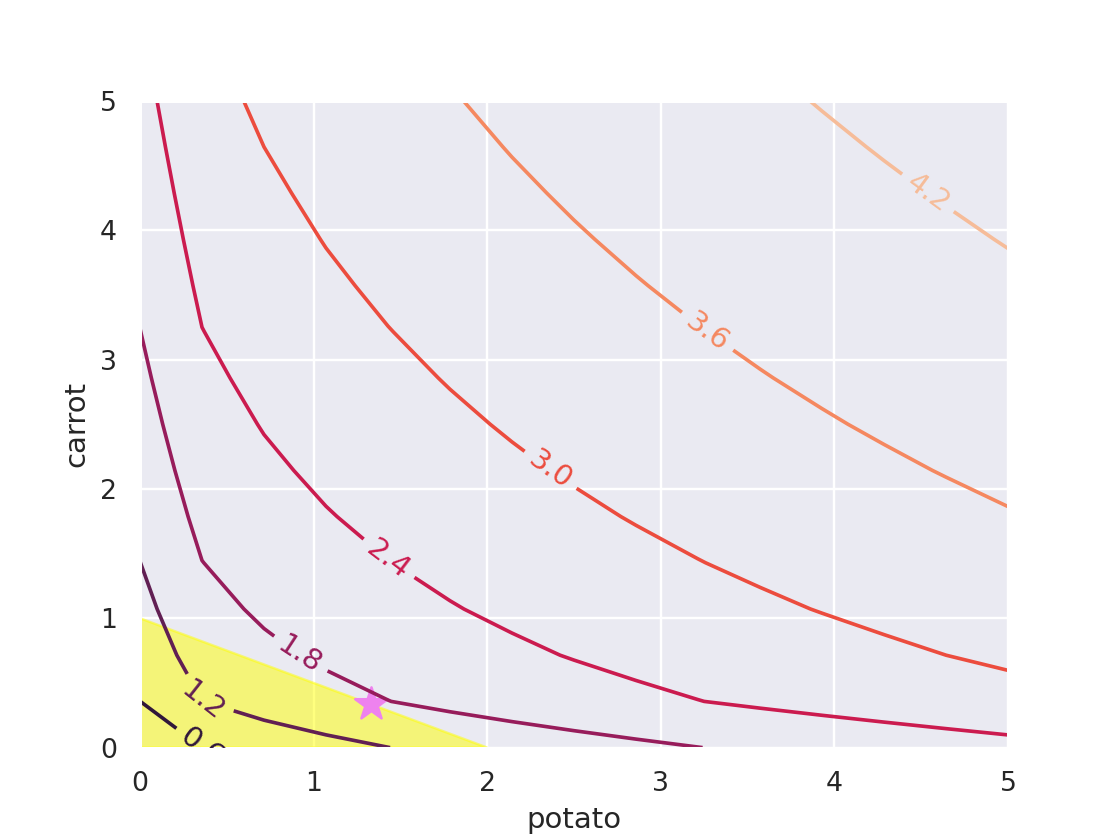

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [23]:
fig = plt.figure()
widgets.interact(plot_feasible_zone_nonlinear, bounds=widgets.fixed(bounds),
                 farmer=widgets.fixed(["bob"]), color=widgets.fixed("yellow"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

# What about collaboration to achieve a non linear objective


## The nature of the firm

<IPython.core.display.Javascript object>


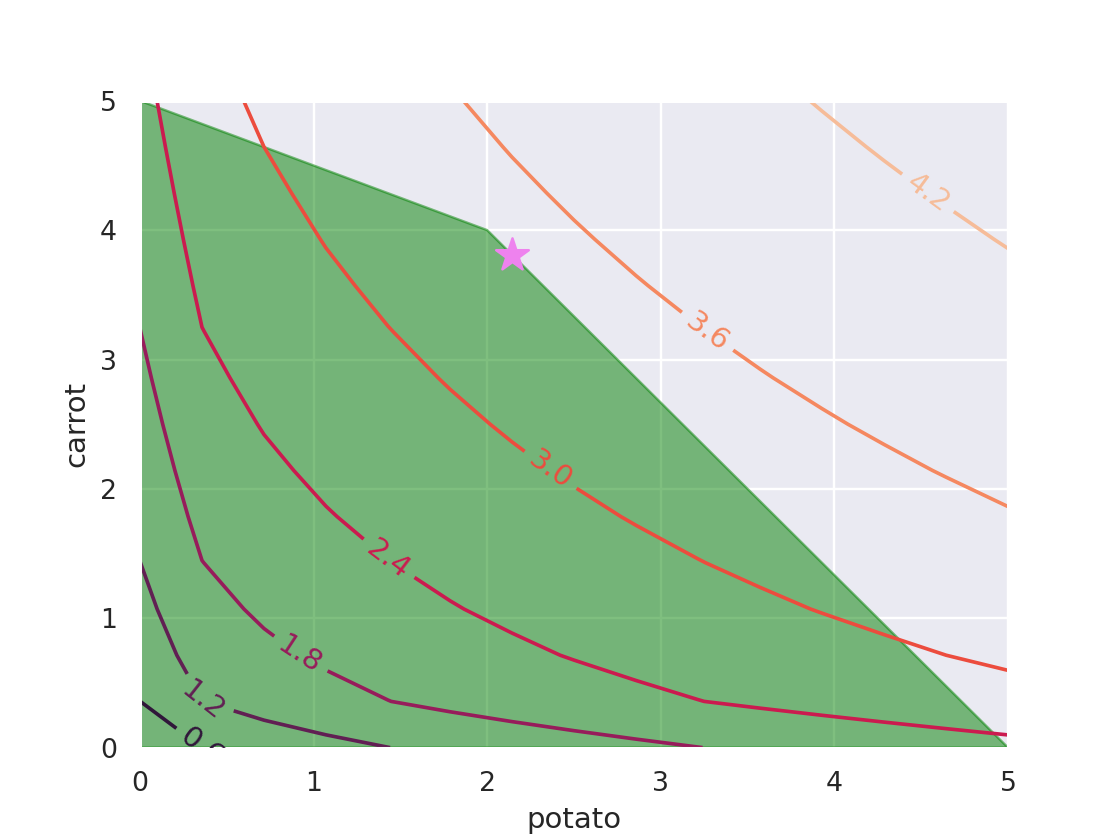

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='ratio', max=5.0, min=-5.0, step=0.25), …

<function __main__.clean_plot.<locals>.g(*args, clean=True, **kwargs)>

In [24]:
fig = plt.figure()
widgets.interact(plot_feasible_zone_nonlinear, bounds=widgets.fixed(bounds),
                 farmer=widgets.fixed(["alice", "bob"]), color=widgets.fixed("green"),
                 ratio=ratio_widget(), clean=widgets.fixed(True))

## Wolf eats wolf

In [25]:
def every_man_for_himself(ratioa, ratiob):
    """Alice and bob produce according to their own preferences and don't trade"""
    Va = get_sublinear_price(ratioa)
    Vb = get_sublinear_price(ratiob)
    Vstara, (pstara, cstara) = optimize_nonlinear_prize(Va, bounds, ["alice"])
    Vstarb, (pstarb, cstarb) = optimize_nonlinear_prize(Vb, bounds, ["bob"])
    return pstara, cstara, pstarb, cstarb, pstara/(pstara+pstarb), cstara/(cstara+cstarb)
every_man_for_himself(1, 1)

(1.2857137666747729,
 2.285711107399445,
 1.3333135874665993,
 0.33333581600593076,
 0.49091269117205694,
 0.8727262909927113)

## Optimal sharing, or trading

In [26]:
def every_man_for_himself_then_share(ratioa, ratiob):
    """Alice and bob produce according to their own preferences and then trade according to their preferences"""
    Va = get_sublinear_price(ratioa)
    Vb = get_sublinear_price(ratiob)
    Vstara, (pstara, cstara) = optimize_nonlinear_prize(Va, bounds, ["alice"])
    Vstarb, (pstarb, cstarb) = optimize_nonlinear_prize(Vb, bounds, ["bob"])

    def sharing_utility(x):
        """See how to best share the carrots and potatoes grown by alice and bob"""
        omegap, omegac = x
        omegap_bar, omegac_bar = 1 - omegap, 1 - omegac
        p = pstara + pstarb
        c = cstara + cstarb
        # No strict need for 'marginal' here, the results would be the same
        # with the absolute utility, but it gives is a sense of scale
        # of the added value of cooperation
        marginal_utility_of_cooperation = \
            Va(omegap*p, omegac*c) - Vstara + \
            Vb(omegap_bar*p, omegac_bar*c) - Vstarb
        return -marginal_utility_of_cooperation

    x0 = np.zeros(2)  #omega
    A = np.identity(2)
    print(A)
    splitresult= scipy.optimize.minimize(fun=sharing_utility,
                                         x0 = x0,
                                         constraints = [
                                             scipy.optimize.LinearConstraint(
                                                 A, np.zeros(2), np.ones(2))],
                                         method="trust-constr",)
    return pstara, cstara, pstarb, cstarb, *splitresult.x
every_man_for_himself_then_share(1, 1)

[[1. 0.]
 [0. 1.]]


(1.2857137666747729,
 2.285711107399445,
 1.3333135874665993,
 0.33333581600593076,
 0.4999999936580257,
 0.49999998799808154)

In [27]:
def optimize_prod_then_share(ratioa, ratiob):
    """Alice and bob optimize their combined production according a common value function, then share"""
    assert ratioa == ratiob, "Can't optimize combined production if preferences are not the same"
    ratio = ratioa
    Vab = get_sublinear_price(ratio)
    Vstarab, (pa, ca, pb, cb) = optimize_nonlinear_prize(Vab, bounds, ["alice", "bob"])

    def sharing_utility(x):
        """See how to best share the carrots and potatoes grown by alice and bob"""
        omegap, omegac = x
        omegap_bar, omegac_bar = 1 - omegap, 1 - omegac
        p = pa+pb
        c = ca+cb
        # No strict need for 'marginal' here, the results would be the same
        # with the absolute utility, but it gives is a sense of scale
        # of the added value of cooperation
        marginal_utility_of_cooperation = Vab(omegap*p, omegac*c) + Vab(omegap_bar*p, omegac_bar*c) - Vstarab
        return -marginal_utility_of_cooperation

    x0 = np.zeros(2)  # omegap, omegac
    A = np.identity(2)
    print(A)
    splitresult= scipy.optimize.minimize(fun=sharing_utility,
                                         x0 = x0,
                                         constraints = [
                                         scipy.optimize.LinearConstraint(
                                             A, np.zeros(2), np.ones(2))],
                                         method="trust-constr",
                                        )
    return pa, ca, pb, cb, *splitresult.x
optimize_prod_then_share(1, 1)

[[1. 0.]
 [0. 1.]]


(0.14292306528253762,
 3.809430203399163,
 1.9999910639273968,
 2.5739934121645942e-06,
 0.4999999815651102,
 0.4999999821848629)

In [28]:
def central_planning(ratioa, ratiob):
    """Alice and bob optimize both their production and trade at the same time"""
    Va = get_sublinear_price(ratioa)
    Vb = get_sublinear_price(ratiob)
    x0 = np.zeros(6)  # pa, ca, pb, cb, omegap, omegac
    # A is a block matrix.
    # The upper 2x4 left block is one line per farmer, one column per farmer*vegetable,
    # The lower 2x2 block is the identity matrix to constraint the omegas
    A = np.zeros((4, 6))
    for i, farmer in enumerate(["alice", "bob"]):
        A[i, 2*i:2*i+2] = np.array([1/bounds[farmer]["potato"],
                                    1/bounds[farmer]["carrot"]])
        A[-2:,-2:] = np.identity(2)
    print(A)

    def gosplan(x):
        """The function to be minimized"""
        pa, ca, pb, cb, omegac, omegap = x
        omegap_bar, omegac_bar = 1 - omegap, 1 - omegac
        p = pa + pb
        c = ca + cb
        # We removed the 'marginal' as even thinking about optimizing
        # on your own will get you the gulag, comrade ;-)
        utility_of_cooperation = Va(omegap*p, omegac*c) + Vb(omegap_bar*p, omegac_bar*c)
        return -utility_of_cooperation

    cpresult= scipy.optimize.minimize(fun=gosplan,
                                      x0 = x0,
                                     constraints = [
                                         scipy.optimize.LinearConstraint(
                                             A,
                                             np.zeros(4),
                                             np.ones(4)),
                                         scipy.optimize.LinearConstraint(
                                             np.identity(6),
                                             np.zeros(6))
                                     ],
                                     method="trust-constr",
                                    )
    return cpresult.x

central_planning(1, 1)

[[0.33333333 0.25       0.         0.         0.         0.        ]
 [0.         0.         0.5        1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


array([1.42866629e-01, 3.80951046e+00, 1.99999862e+00, 4.23905191e-07,
       5.00000191e-01, 5.00000219e-01])

In [29]:
def normalize_results(ratioa, ratiob, method):
    """Return a dictionary detailling the consequences of the given method on the given ratios"""
    answer = {"Method": str(method).split()[1]}
    try:
        pa, ca, pb, cb, omegap, omegac = method(ratioa, ratiob)
        omegap_bar, omegac_bar = 1 - omegap, 1 - omegac
        Va = get_sublinear_price(ratioa)
        Vb = get_sublinear_price(ratiob)
    except AssertionError:
        answer.update(
            {k: float('nan') 
             for k in ['pa', 'ca', 'pb', 'cb', "p'a", "c'a", "p'b", "c'b", "p", "c", "Va", "Vb", "V"]})
        return answer
    answer.update({k:v for k, v in zip(["pa", "ca", "pb", "cb"], [pa, ca, pb, cb])})
    answer["p"] = pa + pb
    answer["c"] = ca + cb
    answer["p'a"] = omegap*answer["p"]
    answer["c'a"] = omegac*answer["c"]
    answer["p'b"] = omegap_bar*answer["p"]
    answer["c'b"] = omegac_bar*answer["c"]
    answer["Va"] = Va(answer["p'a"], answer["c'a"])
    answer["Vb"] = Va(answer["p'b"], answer["c'b"])
    answer["V"] = answer['Va'] + answer['Vb']
    return answer

normalize_results(1, 1, every_man_for_himself)
    
    

{'Method': 'every_man_for_himself',
 'pa': 1.2857137666747729,
 'ca': 2.285711107399445,
 'pb': 1.3333135874665993,
 'cb': 0.33333581600593076,
 'p': 2.619027354141372,
 'c': 2.6190469234053757,
 "p'a": 1.2857137666747729,
 "c'a": 2.285711107399445,
 "p'b": 1.3333135874665993,
 "c'b": 0.3333358160059306,
 'Va': 2.645750031060458,
 'Vb': 1.7320444073796506,
 'V': 4.377794438440109}

In [31]:
pd.DataFrame(data=map(lambda m: normalize_results(1, 1, m),
             [every_man_for_himself, every_man_for_himself_then_share,
             optimize_prod_then_share, central_planning])).set_index("Method")

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[0.33333333 0.25       0.         0.         0.         0.        ]
 [0.         0.         0.5        1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


pa        ca        pb            cb  \
Method                                                                         
every_man_for_himself             1.285714  2.285711  1.333314  3.333358e-01   
every_man_for_himself_then_share  1.285714  2.285711  1.333314  3.333358e-01   
optimize_prod_then_share          0.142923  3.809430  1.999991  2.573993e-06   
central_planning                  0.142867  3.809510  1.999999  4.239052e-07   

                                         p         c       p'a       c'a  \
Method                                                                     
every_man_for_himself             2.619027  2.619047  1.285714  2.285711   
every_man_for_himself_then_share  2.619027  2.619047  1.309514  1.309523   
optimize_prod_then_share          2.142914  3.809433  1.071457  1.904716   
central_planning                  2.142865  3.809511  1.071433  1.904756   

                                       p'b       c'b        Va        Vb  \
Method                                                                     
every_man_for_himself             1.333314  0.333336  2.645750  1.732044   
every_man_for_himself_then_share  1.309514  1.309523  2.288684  2.288684   
optimize_prod_then_share          1.071457  1.904716  2.415227  2.415227   
central_planning                  1.071432  1.904755  2.415230  2.415229   

                                         V  
Method                                      
every_man_for_himself             4.377794  
every_man_for_himself_then_share  4.577368  
optimize_prod_then_share          4.830453  
central_planning                  4.830458

In [266]:
df = pd.DataFrame(data=[
    {"Scenario": "Every man for himself", "pa": pa, "ca": ca, "pb": pb, "cb": cb, "p'a": pa, "c'a": ca, "p'b": pb, "c'b": cb, "p": pa+pb, "c": ca+cb, "Va": Vstara, "Vb": Vstarb, "V": Vstara+Vstarb},
    {"Scenario": "Every man for himself, then share", "pa": pa, "ca": ca, "pb": pb, "cb": cb, "p'a": splitresult.x[0]*(pa+pb), "c'a": splitresult.x[0]*(ca+cb), "p'b": (1-splitresult.x[0])*(pa+pb), "c'b": (1-splitresult.x[0])*(ca+cb), "p": pa+pb, "c": ca+cb, "Va": Va(splitresult.x[0]*(pa+pb),splitresult.x[0]*(ca+cb)) , "Vb": Vb((1-splitresult.x[0])*(pa+pb),(1-splitresult.x[0])*(ca+cb)), "V": Va(splitresult.x[0]*(pa+pb),splitresult.x[0]*(ca+cb)) + Vb((1-splitresult.x[0])*(pa+pb),(1-splitresult.x[0])*(ca+cb)) },
    {"Scenario": "Optimization, then share", "p'a": globalsplitresult.x[0]*p, "c'a": globalsplitresult.x[0]*c, "p'b": (1-globalsplitresult.x[0])*p, "c'b": (1-globalsplitresult.x[0])*c, "p": p, "c": c, "Va": Va(globalsplitresult.x[0]*p,globalsplitresult.x[0]*c) , "Vb": Vb((1-globalsplitresult.x[0])*p,(1-globalsplitresult.x[0])*c), "V": Va(globalsplitresult.x[0]*p,globalsplitresult.x[0]*c) + Vb((1-globalsplitresult.x[0])*p,(1-globalsplitresult.x[0])*c) },
    {"Scenario": "Global optimization", "pa": oresult.x[0], "ca": oresult.x[1], "pb": oresult.x[2], "cb": oresult.x[3], "p'a": oresult.x[4]*(oresult.x[0]+oresult.x[2]), "c'a": oresult.x[4]*(oresult.x[1]+oresult.x[3]),"p'b": (1-oresult.x[4])*(oresult.x[0]+oresult.x[2]), "c'b": (1-oresult.x[4])*(oresult.x[1]+oresult.x[3]), "p": (oresult.x[0]+oresult.x[2]), "c": (oresult.x[0]+oresult.x[2]), "Va": Va(oresult.x[4]*(oresult.x[0]+oresult.x[2]), oresult.x[4]*(oresult.x[1]+oresult.x[3])), "Vb": Vb((1-oresult.x[4])*(oresult.x[0]+oresult.x[2]),(1-oresult.x[4])*(oresult.x[1]+oresult.x[3])), "V": Va(oresult.x[4]*(oresult.x[0]+oresult.x[2]), oresult.x[4]*(oresult.x[1]+oresult.x[3]))+ Vb((1-oresult.x[4])*(oresult.x[0]+oresult.x[2]),(1-oresult.x[4])*(oresult.x[1]+oresult.x[3])) },
    
]).set_index("Scenario")
df

pa        ca        pb            cb  \
Scenario                                                                        
Every man for himself              1.285714  2.285711  1.333314  3.333358e-01   
Every man for himself, then share  1.285714  2.285711  1.333314  3.333358e-01   
Optimization, then share                NaN       NaN       NaN           NaN   
Global optimization                0.142867  3.809510  1.999998  6.832699e-07   

                                        p'a       c'a       p'b       c'b  \
Scenario                                                                    
Every man for himself              1.285714  2.285711  1.333314  0.333336   
Every man for himself, then share  1.309514  1.309523  1.309514  1.309523   
Optimization, then share           1.071457  1.904716  1.071457  1.904716   
Global optimization                1.071433  1.904756  1.071432  1.904755   

                                          p         c        Va        Vb  \
Scenario                                                                    
Every man for himself              2.619027  2.619047  2.645750  1.732044   
Every man for himself, then share  2.619027  2.619047  2.288684  2.288684   
Optimization, then share           2.142914  3.809433  2.415227  2.415227   
Global optimization                2.142865  2.142865  2.415229  2.415229   

                                          V  
Scenario                                     
Every man for himself              4.377794  
Every man for himself, then share  4.577368  
Optimization, then share           4.830453  
Global optimization                4.830458

# Misguided attempts at optimizing in two steps

In [208]:
alice_price, alice_potato, alice_carrot = optimize_nonlinear_prize(get_sublinear_price(1), bounds, ["alice"])
bob_price, bob_potato, bob_carrot = optimize_nonlinear_prize(get_sublinear_price(1), bounds, ["bob"])
sum_price = alice_price+bob_price
sum_potato = alice_potato + bob_potato
sum_carrot = alice_carrot + bob_carrot

def share(alice_potato_share, alice_carrot_share, potato, carrot):
    """Return the concatenated potato, carrot vectors for alice and bob resp."""
    return [alice_potato_share*potato, alice_carrot_share*carrot,
            (1-alice_potato_share)*potato, (1-alice_carrot_share)*carrot]

def incentive_price(potato, carrot):
    """Return the surplus that alice and bob can generate if they collaborate"""
    # We go at it the bruteforce way, but I may be able to derive the formula
    # if given enough time
    def cumulative_happiness(alice_potato_share, alice_carrot_share):
        """Return how happy alice and bob are after sharing their products.
        If any of them is doing worse than they would have done on their own, just return the unhappiness
        (i.e. no exploiting one to make the other happy, this is a voluntary, rational agreement)"""
        alice_carrot, alice_potato, bob_carrot, bob_potato = share(alice_potato_share,
                                                                   alice_carrot_share, potato, carrot)
        # FIXME: parametrize the price landscape, for each actor.
        alice_happiness = get_sublinear_price(1)(alice_potato, alice_carrot) - alice_price
        bob_happiness = get_sublinear_price(1)(bob_potato, bob_carrot) - bob_price
        if alice_happiness < 0 or bob_happiness < 0:
            total_happiness =  (alice_happiness if alice_happiness < 0 else 0) + \
                               (bob_happiness if bob_happiness < 0 else 0)
        else:
            total_happiness = alice_happiness + bob_happiness
        return total_happiness
    oresult = scipy.optimize.minimize(fun=lambda x: -cumulative_happiness(x[0], x[1]),
                                     x0 = np.zeros(2),
                                     constraints = scipy.optimize.LinearConstraint(
                                             np.identity(2), np.zeros(2), np.ones(2)), 
                                     method="trust-constr",)
    return -oresult.fun, share(oresult.x[0], oresult.x[1], potato, carrot)



In [222]:
surplus_happiness, (alice_new_potato, alice_new_carrot, bob_new_potato, bob_new_carrot) = \
    incentive_price(sum_potato, sum_carrot)
alice_new_price = get_sublinear_price(1)(alice_new_potato, alice_new_carrot)
bob_new_price = get_sublinear_price(1)(bob_new_potato, bob_new_carrot)
print(f"""Alice alone gets {alice_price} == {get_sublinear_price(1)(alice_potato, alice_carrot)}
     for {alice_potato} potato and {alice_carrot} carrot.
Bob alone gets {bob_price} == {get_sublinear_price(1)(bob_potato, bob_carrot)}
     for {bob_potato} potato and {bob_carrot} carrot.
That sums to {sum_price} == {alice_price + bob_price}.

If they collaborate, they can share {sum_potato} potato and {sum_carrot} carrot between themselves like so:
Alice gets {get_sublinear_price(1)(alice_new_potato, alice_new_carrot)}
    for {alice_new_potato} potato and {alice_new_carrot} carrot.
Alice gets {get_sublinear_price(1)(bob_new_potato, bob_new_carrot)}
    for {bob_new_potato} potato and {bob_new_carrot} carrot.

That sums to {alice_new_price + bob_new_price}.
which is {surplus_happiness} == {alice_new_price + bob_new_price - sum_price} higher than before""")

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Alice alone gets 2.645750031060458 == 2.645750031060458
     for 1.2857137666747729 potato and 2.285711107399445 carrot.
Bob alone gets 1.7320444073796506 == 1.7320444073796506
     for 1.3333135874665993 potato and 0.33333581600593076 carrot.
That sums to 4.377794438440109 == 4.377794438440109.

If they collaborate, they can share 2.619027354141372 potato and 2.6190469234053757 carrot between themselves like so:
Alice gets 2.645750031333097
    for 1.7654022823040805 potato and 1.734661830153503 carrot.
Alice gets 1.8643358353795523
    for 0.8536250718372917 potato and 0.8843850932518728 carrot.

That sums to 4.510085866712649.
which is 0.13229142827254092 == 0.13229142827254048 higher than before


In [223]:
optimal_price, optimal_potato, optimal_carrot = optimize_nonlinear_prize(
    lambda p, c: incentive_price(p, c)[0], bounds, ["alice", "bob"])
optimal_price, optimal_potato, optimal_carrot

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

(0.02069919492825023, 3.1146643429686387, 1.9847800029639855)

In [226]:
surplus_happiness, (alice_new_potato, alice_new_carrot, bob_new_potato, bob_new_carrot) = \
    incentive_price(optimal_potato, optimal_carrot)
alice_new_price = get_sublinear_price(1)(alice_new_potato, alice_new_carrot)
bob_new_price = get_sublinear_price(1)(bob_new_potato, bob_new_carrot)
print(f"""If they collaborate before deciding what to grow,
they can share {optimal_potato} potato and {optimal_carrot} carrot between themselves like so:
Alice gets {get_sublinear_price(1)(alice_new_potato, alice_new_carrot)}
    for {alice_new_potato} potato and {alice_new_carrot} carrot.
Bob gets {get_sublinear_price(1)(bob_new_potato, bob_new_carrot)}
    for {bob_new_potato} potato and {bob_new_carrot} carrot.

That sums to {alice_new_price + bob_new_price}.
which is {surplus_happiness} == {alice_new_price + bob_new_price - sum_price} higher than before""")

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


If they collaborate before deciding what to grow,
they can share 3.1146643429686387 potato and 1.9847800029639855 carrot between themselves like so:
Alice gets 2.6457500313761506
    for 2.159818664832374 potato and 1.3832532640753348 carrot.
Bob gets 1.752743601992208
    for 0.9548456781362646 potato and 0.6015267388886507 carrot.

That sums to 4.398493633368359.
which is 0.02069919492825023 == 0.02069919492825001 higher than before


In [232]:
def bruteforce_nonlinear_prize(price, bounds, farmers):
    """Return the best price, potato, and carrot for the given price and farmers"""
    x0 = np.zeros(len(farmers)*2)  # Concatenation of the potato, carrot vectors of each farmer
    A = np.zeros((len(farmers), len(farmers)*2))  # One line per farmer, one column per farmer*vegetable
    for i, farmer in enumerate(farmers):
        A[i, 2*i:2*i+2] = np.array([1/bounds[farmer]["potato"],
                                   1/bounds[farmer]["carrot"]])
    #print(A)
    def bounded_price(x):
        if any(A.dot(x)>1) or any(A.dot(x) < 0):
            return 1000
        return -price(sum(x[::2]), sum(x[1::2]))
    oresult= scipy.optimize.brute(func=bounded_price,
                                  ranges = ((0,2), (0, 1), (0, 3), (0, 4)),
                                  Ns = 5,
                                  full_output=True,)
    return oresult
bruteforce_nonlinear_prize(lambda p, c: incentive_price(p, c)[0], bounds, ["alice", "bob"])

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/gnu/store/y106i86k5mkr9nyhgmd448vyksb9ab4b-profile/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If

(array([ 2.00597679e+00,  1.32329197e+00,  1.99655470e+00, -7.75740170e-04]),
 0.01391684965859774,
 array([[[[[0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ]],
 
          [[0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ]],
 
          [[0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ]],
 
          [[0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  , 0.  , 0.  ]],
 
          [[0.  , 0.  , 0.  

In [36]:
ps = get_sublinear_price(1)
ps(1.4, 2)

2.5974295189930183

In [37]:
ss.bestf(1, [1.4, 2])

(2.5974295189930183, 1.4, 2)